# Variational Quantum Eigensolver (VQE)

VQE is a hybrid algorithm combining classical and quantum computing to find ground state energies. The 4 main components are:

1. **Operator**: Usually a Hamiltonian; we seek the eigenvector corresponding to the minimum eigenvalue (the "ground state")
2. **Ansatz**: A parameterized quantum circuit that prepares a quantum state approximating the desired eigenvector
3. **Estimator**: Computes expectation values of the operator over the quantum state
4. **Classical Optimizer**: Varies circuit parameters to minimize the cost function

## Custom Ansatz Implementation

Here I construct a custom ansatz using RY and RZ rotation gates with a linear entangling layer (CNOT). This provides insight when compared to IBM's prebuilt ansatze like EfficientSU2.

In [15]:
from qiskit.circuit import Parameter, QuantumCircuit, ParameterVector
import numpy as np
from molecules import h2_qubit_hamiltonian, exact_energy

qubit_op, problem = h2_qubit_hamiltonian(0.75)
num_qubits = qubit_op.num_qubits

def hardware_efficient_ansatz(num_qubits, depth):
    qc = QuantumCircuit(num_qubits)

    # Create parameters
    num_params = 2 * num_qubits * depth
    params = ParameterVector("θ", num_params)
    
    param_idx = 0

    for d in range(depth):
        # Single-qubit rotations
        for q in range(num_qubits):
            qc.ry(params[param_idx], q)
            param_idx += 1
            qc.rz(params[param_idx], q)
            param_idx += 1

        # Entangling layer (linear chain)
        for q in range(num_qubits - 1):
            qc.cx(q, q + 1)

    return qc



## Optimizer and Estimator Setup

Setup for two classical optimizers (COBYLA and SPSA) with the Estimator for evaluating expectation values.

In [ ]:
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Estimator as AerEstimator  
import matplotlib.pyplot as plt

shots = 2000  # fixed shot budget per evaluation

estimator = Estimator(options={"shots": shots})

ansatz = hardware_efficient_ansatz(num_qubits, depth=2)

## Prebuilt Ansatz Comparison

Compare custom ansatz against IBM's prebuilt TwoLocal ansatz to evaluate relative performance.

In [17]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(
    num_qubits=num_qubits,
    rotation_blocks=["ry", "rz"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=2,
)


In [ ]:
depths = [1,2,3]
optimizers = {
    "COBYLA": COBYLA(maxiter=200),
    "SPSA" : SPSA(maxiter=200)
}


R_values = np.linspace(0.3, 2.0, 12)
results = []

for R in R_values:
    qubit_op, problem = h2_qubit_hamiltonian(R)
    num_qubits = qubit_op.num_qubits

    for depth in depths:
        for name, opt in optimizers.items():
            ansatz = hardware_efficient_ansatz(num_qubits, depth)

            vqe = VQE(
                estimator=estimator,
                ansatz=ansatz,
                optimizer=opt,
            )

            res = vqe.compute_minimum_eigenvalue(qubit_op)
            E_exact = exact_energy(qubit_op, problem)

            results.append({
                "R": R,
                "depth": depth,
                "optimizer": name,
                "energy": res.eigenvalue.real + problem.nuclear_repulsion_energy,
                "energy_exact": E_exact,
                "iters": res.optimizer_result.nfev,
            })


In [ ]:
two_local_results = []

depth = 2  # Matching the reps in TwoLocaL 
optimizer = COBYLA(maxiter=200)
estimator = Estimator()

for R in R_values:
    qubit_op, problem = h2_qubit_hamiltonian(R)
    num_qubits = qubit_op.num_qubits

    two_local_ansatz = TwoLocal(
        num_qubits=num_qubits,
        rotation_blocks=["ry", "rz"],
        entanglement_blocks="cz",
        entanglement="full",
        reps=depth,
        parameter_prefix="θ",
    )

    vqe = VQE(
        estimator=estimator,
        ansatz=two_local_ansatz,
        optimizer=optimizer,
    )

    res = vqe.compute_minimum_eigenvalue(qubit_op)

    two_local_results.append({
        "R": R,
        "energy": res.eigenvalue.real + problem.nuclear_repulsion_energy,
        "reps": depth,
        "optimizer": "COBYLA",
    })
    


In [20]:
import matplotlib.pyplot as plt

# Extract summary data from results for initial comparison
R_vals = sorted(set(r["R"] for r in results))

E_vqe = []
E_exact = []

for R in R_vals:
    # Get first result (could filter for specific depth/optimizer)
    vals = [r for r in results if r["R"] == R]
    if vals:
        E_vqe.append(vals[0]["energy"])
        E_exact.append(vals[0]["energy_exact"])

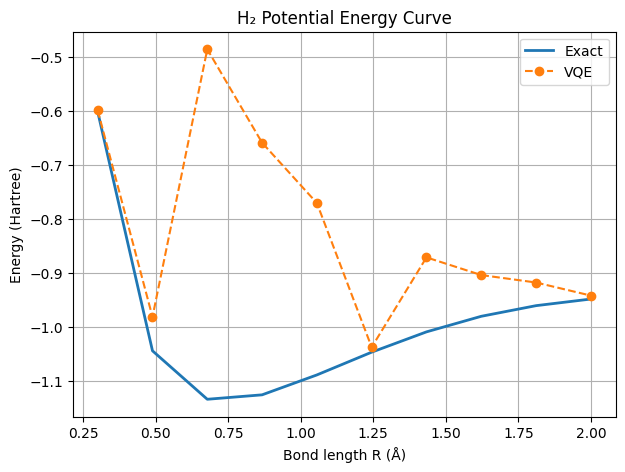

In [21]:
plt.figure(figsize=(7, 5))

plt.plot(R_vals, E_exact, label="Exact", linewidth=2)
plt.plot(R_vals, E_vqe, marker="o", linestyle="--", label="VQE")

plt.xlabel("Bond length R (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("H₂ Potential Energy Curve")
plt.legend()
plt.grid(True)
plt.show()




In [22]:
def extract_curve(results, depth, optimizer):
    R = []
    E = []

    for entry in results:
        if entry["depth"] == depth and entry["optimizer"] == optimizer:
            R.append(entry["R"])
            E.append(entry["energy"])

    # Sort by R (important!)
    R, E = zip(*sorted(zip(R, E)))
    return R, E

def extract_exact_curve(results):
    exact_dict = {}

    for entry in results:
        R = entry["R"]
        if R not in exact_dict:
            exact_dict[R] = entry["energy_exact"]

    R_exact = sorted(exact_dict.keys())
    E_exact = [exact_dict[R] for R in R_exact]

    return R_exact, E_exact


R_exact, E_exact = extract_exact_curve(results)

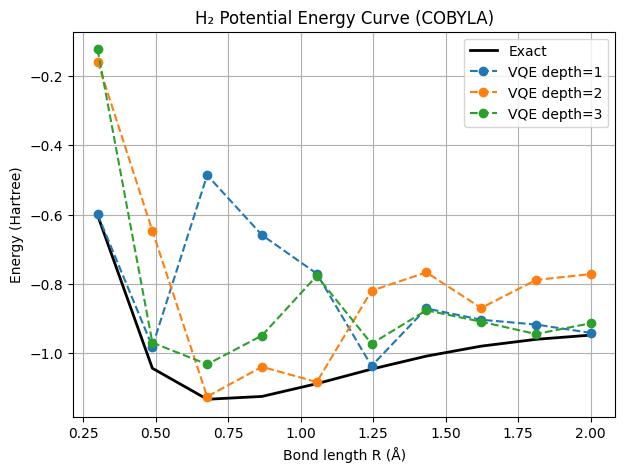

In [23]:
plt.figure(figsize=(7, 5))

plt.plot(R_exact, E_exact, color="black", linewidth=2, label="Exact")

for depth in [1, 2, 3]:
    R, E = extract_curve(results, depth, "COBYLA")
    plt.plot(
        R, E,
        marker="o",
        linestyle="--",
        label=f"VQE depth={depth}"
    )

plt.xlabel("Bond length R (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("H₂ Potential Energy Curve (COBYLA)")
plt.legend()
plt.grid(True)
plt.show()


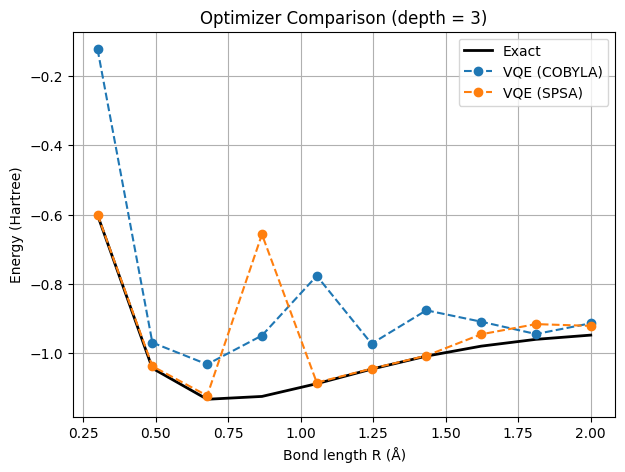

In [24]:
plt.figure(figsize=(7, 5))

plt.plot(R_exact, E_exact, color="black", linewidth=2, label="Exact")

for optimizer in ["COBYLA", "SPSA"]:
    R, E = extract_curve(results, depth=3, optimizer=optimizer)
    plt.plot(
        R, E,
        marker="o",
        linestyle="--",
        label=f"VQE ({optimizer})"
    )

plt.xlabel("Bond length R (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("Optimizer Comparison (depth = 3)")
plt.legend()
plt.grid(True)
plt.show()



## Energy Comparison: Exact vs TwoLocal Ansatz

Plot exact ground state energies against VQE results using TwoLocal ansatz with full entanglement.

In [25]:
# Build exact and TwoLocal results data
R_exact_tl = []
E_exact_tl = []

for R in R_values:
    qubit_op, problem = h2_qubit_hamiltonian(R)
    E_exact_tl.append(exact_energy(qubit_op, problem))
    R_exact_tl.append(R)
    
R_tl = [entry["R"] for entry in two_local_results]
E_tl = [entry["energy"] for entry in two_local_results]

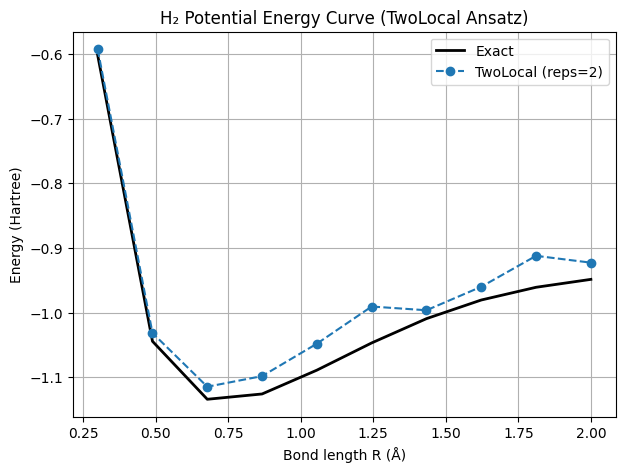

In [26]:

plt.figure(figsize=(7, 5))

plt.plot(R_exact, E_exact, color="black", linewidth=2, label="Exact")
plt.plot(R_tl, E_tl, marker="o", linestyle="--", label="TwoLocal (reps=2)")

plt.xlabel("Bond length R (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("H₂ Potential Energy Curve (TwoLocal Ansatz)")
plt.legend()
plt.grid(True)
plt.show()


## Ansatz Comparison: Custom vs TwoLocal

Compare the custom hardware-efficient ansatz against the TwoLocal prebuilt ansatz.

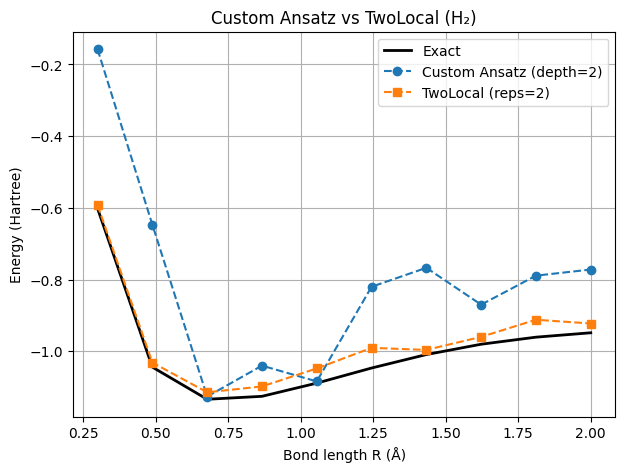

In [27]:
R_custom = []
E_custom = []

for entry in results:
    if entry["depth"] == 2 and entry["optimizer"] == "COBYLA":
        R_custom.append(entry["R"])
        E_custom.append(entry["energy"])

# Sort
R_custom, E_custom = zip(*sorted(zip(R_custom, E_custom)))

plt.figure(figsize=(7, 5))

plt.plot(R_exact, E_exact, color="black", linewidth=2, label="Exact")
plt.plot(R_custom, E_custom, marker="o", linestyle="--", label="Custom Ansatz (depth=2)")
plt.plot(R_tl, E_tl, marker="s", linestyle="--", label="TwoLocal (reps=2)")

plt.xlabel("Bond length R (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("Custom Ansatz vs TwoLocal (H₂)")
plt.legend()
plt.grid(True)
plt.show()



## Equilibrium Geometry Analysis

Estimate the equilibrium bond length (Re) and equilibrium energy E(Re) for H₂ using fine-grained exact diagonalization and quadratic interpolation.

In [28]:
# Estimate equilibrium bond length Re and equilibrium energy E(Re)
# Uses exact diagonalization on a fine grid and quadratic interpolation
import numpy as np

R_fine = np.linspace(0.3, 2.0, 401)  # fine grid
E_fine = np.empty_like(R_fine)

for i, R in enumerate(R_fine):
    qubit_op, problem = h2_qubit_hamiltonian(R)
    E_fine[i] = exact_energy(qubit_op, problem)

# Find index of minimum energy
idx = int(np.argmin(E_fine))

# Quadratic interpolation around the minimum for a refined estimate
if 0 < idx < len(R_fine) - 1:
    x = R_fine[idx - 1: idx + 2]
    y = E_fine[idx - 1: idx + 2]
    a, b, c = np.polyfit(x, y, 2)
    R_est = -b / (2 * a)
    E_est = a * R_est ** 2 + b * R_est + c
else:
    R_est = R_fine[idx]
    E_est = E_fine[idx]

print(f"Estimated equilibrium bond length Re = {R_est:.6f} Å")
print(f"Estimated equilibrium energy E(Re) = {E_est:.6f} Ha")



Estimated equilibrium bond length Re = 0.734878 Å
Estimated equilibrium energy E(Re) = -1.137306 Ha


## Summary and Analysis

This section provides a comprehensive summary of the VQE results and key insights.

In [ ]:
# Compute average error for depth=2, COBYLA
depth2_cobyla_results = [d for d in results if d['depth'] == 2 and d['optimizer'] == 'COBYLA']
avg_error = np.mean([abs(e['energy'] - e['energy_exact']) for e in depth2_cobyla_results]) if depth2_cobyla_results else 0

# Display comprehensive summary

print("VQE CALCULATION SUMMARY")

print(f"Estimated Re (Å)                    {R_est:.6f}")
print(f"Estimated E(Re) (Ha)                {E_est:.6f}")
print(f"Number of R-points sampled          {len(R_values)}")
print(f"Number of ansatz depths tested      {len(depths)}")
print(f"Number of optimizers tested         {len(optimizers)}")
print(f"Total VQE calculations              {len(results)}")
print(f"Average error (depth=2, COBYLA)     {avg_error:.6f}")


# Display equilibrium geometry results
print("EQUILIBRIUM GEOMETRY (H₂)")

print(f"Bond length Re = {R_est:.6f} Å")
print(f"Energy E(Re)   = {E_est:.6f} Ha")
print(f"Experimental Re ≈ 0.741 Å (for reference)")



VQE CALCULATION SUMMARY
Estimated Re (Å)                    0.734878
Estimated E(Re) (Ha)                -1.137306
Number of R-points sampled          10
Number of ansatz depths tested      3
Number of optimizers tested         2
Total VQE calculations              60
Average error (depth=2, COBYLA)     0.186697

EQUILIBRIUM GEOMETRY (H₂)
----------------------------------------
Bond length Re = 0.734878 Å
Energy E(Re)   = -1.137306 Ha
Experimental Re ≈ 0.741 Å (for reference)
----------------------------------------
